# Age Prediction from Photos

Supermarket chain X aims to implement a computer vision system to analyze customer photos for age prediction. This system serves two primary objectives: ensuring compliance with alcohol sale regulations and personalizing product offerings.

**Our goal:** develop a machine learning model to predict customer's age from photos, with a target quality metric Mean Absolute Error (MAE) of less than 8.

**Data:** dataset with 7591 images provided by [ChaLearn Looking at People](https://chalearnlap.cvc.uab.es/dataset/26/description/). File `labels.csv` contains `file_name` and `real_age` columns.

**Research plan**

1. Data loading and overview.
2. Neural network training.
3. Research conclusion.

## 1. Data load and overview

First we will import all necessary libraries.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 12345

Next, we will load the dataset and verify that the number of images and the columns match the project description.

In [2]:
# Load dataset
labels = pd.read_csv('D:\jupyter_notebooks\Computer_Vision\dataset\labels.csv')
print('Number of images:', labels.shape[0])
labels.info()

Number of images: 7591
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
# Print first 5 rows
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Dataset matches the description provided by the customer. No missing data was found.

Let's look at the histogram of the `real_age` distribution.

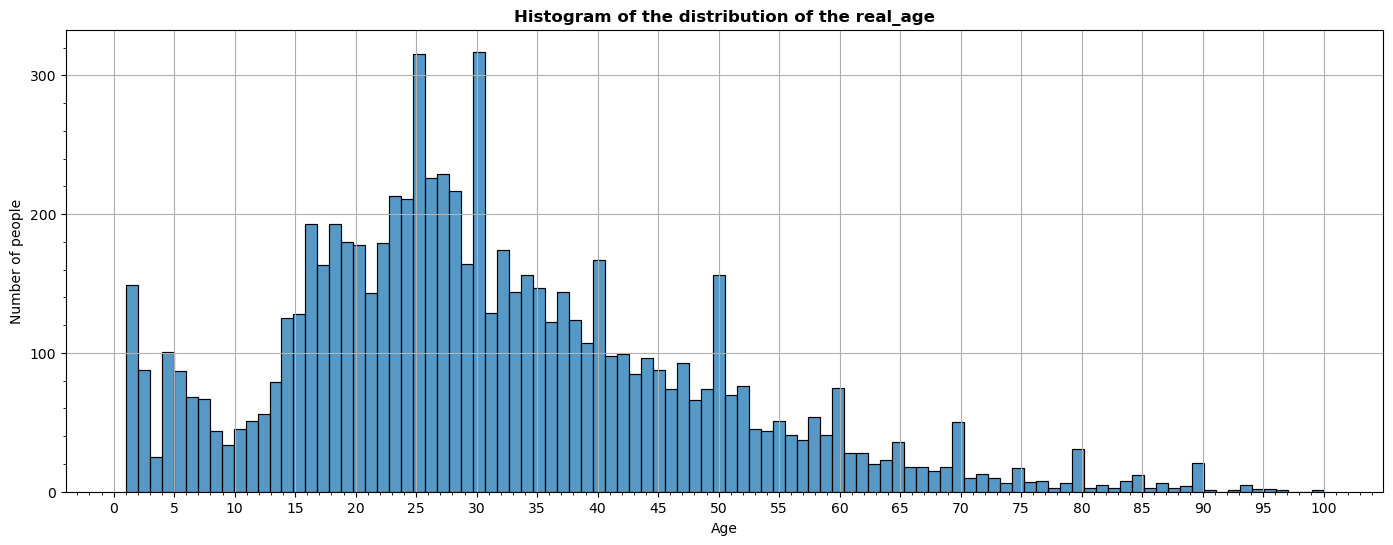

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [4]:
# Histogram and descriptive statistics
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17,6))
ax.set_title('Histogram of the distribution of the real_age',
             fontweight='semibold')
ax.set_xlabel('Age')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_ylabel('Number of people')
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.grid()
sns.histplot(labels,
             x='real_age',
             bins=100,
             ax=ax)        
plt.show()

labels['real_age'].describe()

Let's look at the images in the dataset.

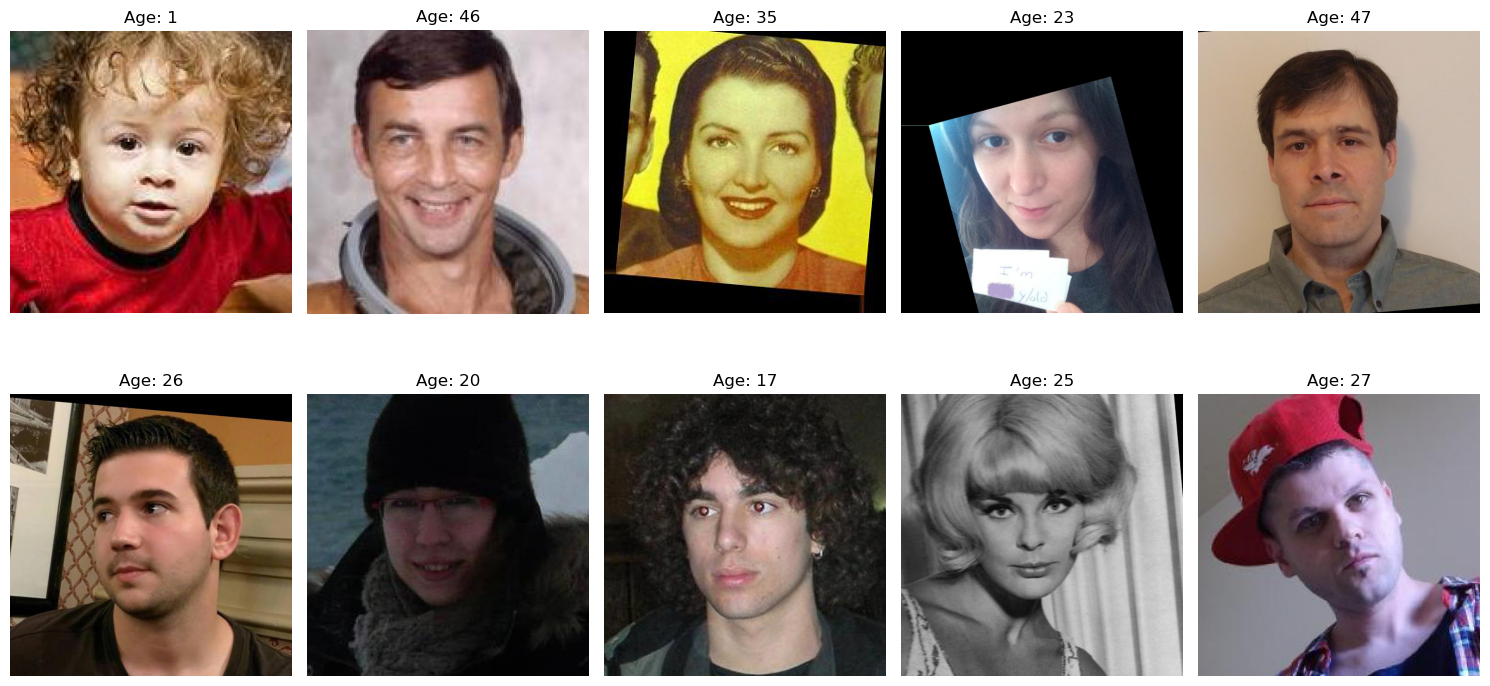

In [5]:
# Select 10 random images
random_images = labels.sample(10, random_state=42).index

# Show images and real_age
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_images):
    file_name = labels['file_name'].iloc[idx]
    file_path = r'D:\jupyter_notebooks\Computer_Vision\dataset\faces\\' + file_name
    
    image = plt.imread(file_path)
    
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"Age: {labels['real_age'].iloc[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Summary

The dataset contains photos of people aged between 1 and 100 years, most of the photos belong to people of 25 and 30 years. Notably, the histogram shows peaks at ages that are multiples of 5. This suggests that the exact age was not known for all photos, and the remaining data may have been labeled manually or by estimation (people tend to round numbers).

The photos vary in quality. Some images show shifts and rotations, which are the result of attempts to "crop" and enlarge the face.

Applying augmentations, such as flips, can improve the model's performance. Since we are dealing with photos of people, we will apply horizontal flip (if a person is looking to the right, they will be looking to the left after flipping).

## 2. Neural network training

We are solving a regression problem since age is a quantitative feature.

To achieve our goal, we will build a neural network based on the ResNet50 architecture. We will use pretrained `imagenet` weights, which will allow us to significantly improve the quality of the model. For model optimization, we will use the `Adam` algorithm.

Age cannot be negative, which is why we chose the `ReLU` activation function: it replaces negative outcomes with 0.

Even though our target quality metric is Mean Absolute Error (MAE), we will use Mean Squared Error (MSE) as the loss function. MSE is preferred as a loss function due to its smoother gradient properties and stronger penalization of large errors.

Let's prepare the training and testing data.

In [6]:
# Training data
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    horizontal_flip=True,
    rescale=1./255,
    dtype='float32')
    
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=r'D:\jupyter_notebooks\Computer_Vision\dataset\faces\\',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=RANDOM_STATE)

Found 5694 validated image filenames.


In [7]:
# Testing data, augmentations are off
test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    dtype='float32')
    
test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=r'D:\jupyter_notebooks\Computer_Vision\dataset\faces\\',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=RANDOM_STATE)

Found 1897 validated image filenames.


Next, let's assemble our neural network.

In [8]:
# Neural network with pretrained weights
backbone = ResNet50(
    #input_shape=(224, 224, 3), 
    include_top=False,
    weights='imagenet')

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1, activation='relu'))
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='mse', 
              metrics=['mae'])

Finally, let's train the model.

In [9]:
model.fit(train_gen_flow,
          validation_data=test_gen_flow,
          epochs=5,
          batch_size=16,
          steps_per_epoch=len(train_gen_flow),
          validation_steps=len(test_gen_flow),
          verbose=1)

Epoch 1/5
356/356 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - loss: 368.3345 - mae: 14.0373 - val_loss: 463.0451 - val_mae: 16.4222
Epoch 2/5
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 3/5
356/356 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - loss: 86.7074 - mae: 7.0258 - val_loss: 171.4736 - val_mae: 9.8066
Epoch 4/5
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 5/5
356/356 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - loss: 65.6549 - mae: 6.1745 - val_loss: 98.0147 - val_mae: 7.4280


The model has achieved required quality with Mean Absolute Error 7.43 on the test dataset.

## 3. Research conclusion

The goal of the project was to develop a machine learning model to predict customer's age from photos, with a target quality metric Mean Absolute Error (MAE) of less than 8.

To achieve this goal we built a neural network based on the ResNet50 architecture, using the Adam optimization algorithm and pretrained ImageNet weights. Mean Squared Error (MSE) was used as the loss function, since it is preferred due to its smoother gradient properties and stronger penalization of large errors.

Since this is a regression problem, the final fully connected layer contains a single neuron with a ReLU activation function to ensure that the predictions are non-negative (age is always positive). The model was trained for 5 epochs without freezing the weights, as freezing the weights significantly degraded the model's performance (MAE > 22).

On the training dataset, both the loss function (MSE) and the quality metric (MAE) consistently decreased with each epoch. This indicates that the model effectively learns from the training data.

On the test dataset, both the loss function (MSE) and the quality metric (MAE) also consistently decreased with each epoch. This suggests that the model has good generalization capability and is not merely memorizing the data.

No significant overfitting was detected, as the metrics on the training and test data differ only slightly.

The MAE on the test dataset is 7.43, indicating that, on average, the model's age predictions are off by this many years for the people in the photos.

The model has achieved required quality and can be utilized for customer's computer vision system.